# Mydatapreprocessing

## Data load, consolidation, conversion a preprocessing

## [Documentation](https://mydatapreprocessing.readthedocs.io/)

## [Github repo](https://github.com/Malachov/mydatapreprocessing)

## Installation and import

    pip install mydatapreprocessing

There are some extra libraries that may be necessary for some functionality (h5 and parquet). If import error, install library. If you want to install all extra libraries at once, download [requirements](https://github.com/Malachov/mydatapreprocessing/blob/master/requirements_advanced.txt) and install all with

    pip install -r requirements_advanced.txt

In [1]:
import mydatapreprocessing as mdp
import pandas as pd

## Load data

You can use

- python formats (numpy.ndarray, pd.DataFrame, list, tuple, dict)
- local files
- web urls

Supported path formats are:

- csv
- xlsx and xls
- json
    - parquet
    - h5

In [2]:
data_loaded = mdp.load_data.load_data("https://raw.githubusercontent.com/Malachov/mydatapreprocessing/master/tests/test_files/list.json")

print(data_loaded.head())


         Date    Mean   Source
0  1881-03-06  0.0100  GISTEMP
1  1881-02-06 -0.0296     GCAG
2  1881-02-06 -0.1400  GISTEMP
3  1881-01-06 -0.0205     GCAG
4  1881-01-06 -0.1000  GISTEMP


Sometime you need to add arguments to load data correctly

In [3]:
# data_loaded = mdp.load_data.load_data("different_structure/web_request", request_datatype_suffix=".json", field='data', data_orientation="index")

## Load data from disk

<AxesSubplot:>

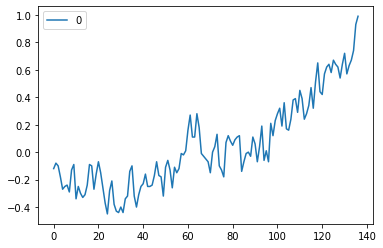

In [4]:
data = mdp.load_data.load_data(r"tests/test_files/tested_data.csv")  # If necessary edit csv_style={'sep': ';', 'decimal': ','}, header=6
data.plot()

## Load more data files at once

### Get list of paths

You can select data simply with dialog window

Uncomment line to try it out

In [5]:
paths = ["tests/test_files/tested_data.csv", "tests/test_files/tested_data2.csv"]
# paths = mdp.load_data.get_file_paths()
print(paths)

['tests/test_files/tested_data.csv', 'tests/test_files/tested_data2.csv']


In [6]:
data = mdp.load_data.load_data(paths, csv_style={'sep': ';', 'decimal': ','}, header=6)
# Length is twice as long as two files was used
print(data.head())

   -0.25
0  -0.24
1  -0.29
2  -0.13
3  -0.09
4  -0.34


## Consolidation

Remove NaN values, resample or do string embedding

In [7]:
data = mdp.load_data.load_data(r"https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv")

# You can use intellisense and docs tooltip or you can use 'update' function with dict of
# values (no need of subconfig then)
consolidation_config = mdp.consolidation.consolidation_config.default_consolidation_config.copy()
consolidation_config.datetime.datetime_column = 'Date'
consolidation_config.resample.resample = 'M'
consolidation_config.resample.resample_function = "mean"
consolidation_config.dtype = 'float32'

data = mdp.consolidation.consolidate_data(data, consolidation_config)
print(data.head())

                 Temp
Date                 
1981-01-31  17.712904
1981-02-28  17.678572
1981-03-31  13.500000
1981-04-30  12.356667
1981-05-31   9.490322


## Format conversion

Because data are consolidated (everytime in the same format), it's very simple to convert it to any format.


In [8]:
parquet_converted = data.to_parquet('tests/test_files/data.parquet')

## Feature extraction

Create new columns that can be for example used as another machine learning model input.

In [9]:
import mydatapreprocessing.feature_engineering as mdpf
import mydatapreprocessing as mdp

data = pd.DataFrame(
    [mdp.datasets.sin(n=30), mdp.datasets.ramp(n=30)]
).T

extended = mdpf.add_derived_columns(data, differences=True, rolling_means=10)
print(extended.columns)
print(f"\nit has less rows then on input {len(extended)}")

Index([                      0,                       1,
              '0 - Difference',        '1 - Difference',
       '0 - Second difference', '1 - Second difference',
        'Multiplicated (0, 1)',      '0 - Rolling mean',
            '1 - Rolling mean',       '0 - Rolling std',
             '1 - Rolling std',     '0 - Mean distance',
           '1 - Mean distance'],
      dtype='object')

it has less rows then on input 21


## Preprocessing

Functions for smoothing, standardization, outliers removal etc...


In [10]:
import numpy as np
import pandas as pd
from mydatapreprocessing import preprocessing as mdpp

df = pd.DataFrame(np.array([range(5), range(20, 25), np.random.randn(5)]).astype("float32").T)
df.iloc[2, 0] = 500
print("\nInput data: \n", df)

config = mdpp.preprocessing_config.default_preprocessing_config.copy()
config.update({"remove_outliers": None, "difference_transform": True, "standardize": "standardize"})

data_preprocessed, inverse_config = mdpp.preprocess_data(df.values, config)
print("\nPreprocessed: \n", data_preprocessed)

# If using for prediction, default last value is used for inverse transform. Here for test using first value
# is used to check whether original data will be restored.
inverse_config.difference_transform = df.iloc[0, 0]
data_preprocessed_inverse = mdpp.preprocess_data_inverse(data_preprocessed[:, 0], inverse_config)
print("\nInverse preprocessed: \n", data_preprocessed_inverse)
print("\nIs the inverse preprocessed data same like before preprocessing: \n", np.allclose(df.values[1:, 0], data_preprocessed_inverse, atol=1.0e-5))


Input data: 
        0     1         2
0    0.0  20.0  0.268165
1    1.0  21.0  1.843659
2  500.0  22.0  0.813387
3    3.0  23.0  0.467159
4    4.0  24.0 -0.696764

Preprocessed: 
 [[ 0.          0.          1.660954  ]
 [ 1.4142135   0.         -0.7213848 ]
 [-1.4142135   0.         -0.0959927 ]
 [ 0.          0.         -0.84357643]]

Inverse preprocessed: 
 [  1. 500.   3.   4.]

Is the inverse preprocessed data same like before preprocessing: 
 True
